In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import dataset
import myModels
import matplotlib.pyplot as plt
import scienceplots
import time
import Metrics
import LossFn

plt.style.use('science')
plt.rcParams['text.usetex'] = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [36]:
params = {
    'paths': os.path.abspath(os.path.join(os.getcwd(),'..')) + '/Datas/Thermal/',
    'inputs_FileName': ['Strains-50-1.xlsx','Strains-50-2.xlsx','Strains-100-1.xlsx','Strains-100-2.xlsx','Strains-120-1.xlsx'],
    'outputs_FileName': ['Loads-50-1.xlsx','Loads-50-2.xlsx','Loads-100-1.xlsx','Loads-100-2.xlsx','Loads-120-1.xlsx'],
    'SampleStride': [1,1,10,10,5],
    'seq_len': 100,
    'input_size': 14,
    'output_size': 6,
    'state':True,
    'Mask':True,
    'Robust_loss':False,
    'Noise_level': 0.0,
    'batch_size': 32,
    'lstm_layers': [25,48,48,25],
    'dropout':0.1,
    'Epoches': 1500,
    'lr':0.001,
    'dis_interval':200,
    'plot_loss':True,
    'device':device,
}


In [37]:
Data_set = dataset.MyDataset(params)
test_size = int(len(Data_set)*0.1)
train_set, test_set = torch.utils.data.random_split(Data_set, [len(Data_set) - test_size, test_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=params['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_size, shuffle=True)

Train Epoch: 0, loss: 2834.077890
--------------------------------------------------------
Train Epoch: 200, loss: 8.693489
--------------------------------------------------------
Train Epoch: 400, loss: 6.135423
--------------------------------------------------------
Train Epoch: 600, loss: 10.602919
--------------------------------------------------------
Train Epoch: 800, loss: 1.303918
--------------------------------------------------------
Train Epoch: 1000, loss: 1.139539
--------------------------------------------------------
Train Epoch: 1200, loss: 2.856007
--------------------------------------------------------
Train Epoch: 1400, loss: 2.925891
--------------------------------------------------------
Train Epoch: 1499, loss: 1.197571
--------------------------------------------------------
***********************  Train is done  ***********************
Training complete in 14m 37s


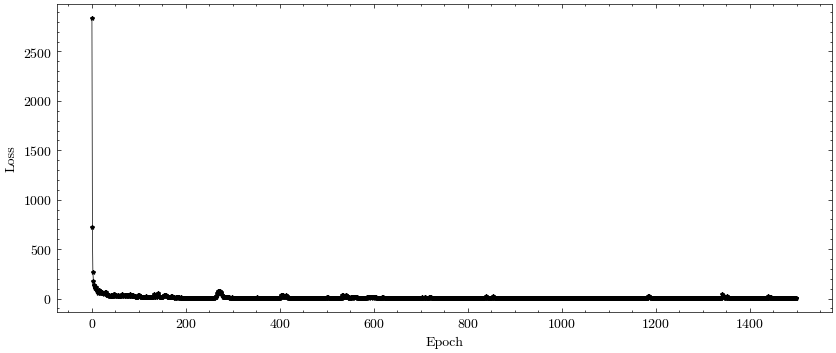

In [38]:
models = myModels.deepLSTM(params).to(device)
if params['Robust_loss']:
    loss_fn = LossFn.UncertaintyLoss(params)
    all_parameters = list(models.parameters()) + list(loss_fn.parameters())
else:
    loss_fn = nn.MSELoss()
    all_parameters = models.parameters()
    
optimizer = optim.Adam(all_parameters, params['lr'])
losses = models._Train(optimizer,train_loader,loss_fn)

In [40]:
torch.save(models,'LSTM.pt')

0.9887752736693639


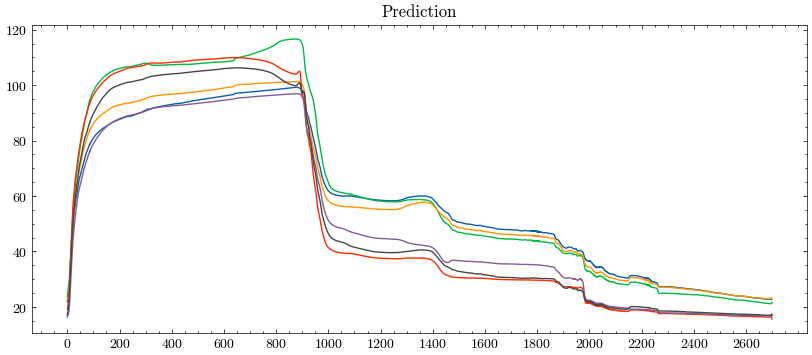

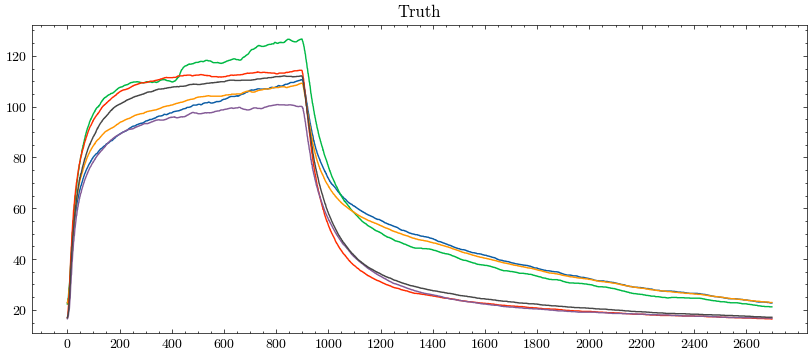

In [39]:
#models = torch.load('LSTM.pt')
labels = 4
start = 0
end = 2700
plot_step = 200
loads,preds = myModels.predict_varylength(models,params,labels,start,end,mask=False)
print (Metrics.Com_pearsonr(loads,preds))
plt.figure(figsize=(10,4))
plt.plot(preds.detach().numpy())
plt.title('Prediction')
plt.xticks(np.arange(0, end - start + 1, step=plot_step), np.arange(start, end + 1, step=plot_step))
plt.show()
plt.figure(figsize=(10,4))
plt.plot(loads.cpu().detach().numpy())
plt.title('Truth')
plt.xticks(np.arange(0, end - start + 1, step=plot_step), np.arange(start, end + 1, step=plot_step))
plt.show()

In [24]:
from math import ceil,floor



def getDatas(params):
    Strains = []
    Loads = []
    if (len(params['Strains_FileName']) == len(params['Loads_FileName'])):
        FilesNum = len(params['Strains_FileName'])
        for num in range(FilesNum): #load data from each file
            strain = torch.tensor(dataset.getDataFromFile(params['Strains_FileName'][num],params['paths'],params['state']).values) #transfor to torch.tensor
            print (strain.size())
            load = torch.tensor(dataset.getDataFromFile(params['Loads_FileName'][num],params['paths'],state=True).values)
            data_length = strain.size(0) # compute length of each exprimental data
            
            if ((data_length-params['seq_len'])/params['SampleStride'][num]+1).is_integer(): # determine whether it can be rounded
                
                for i in range(floor(((data_length-params['seq_len'])/params['SampleStride'][num]+1))):
                    Strains.append(strain[i*params['SampleStride'][num]:params['seq_len']+i*params['SampleStride'][num]])
                    Loads.append(load[i*params['SampleStride'][num]:params['seq_len']+i*params['SampleStride'][num]]) 
                    
            else:                                                         # for 100-1 file
                for i in range(floor(((data_length-params['seq_len'])/params['SampleStride'][num]+1))):
                    Strains.append(strain[i*params['SampleStride'][num]:params['seq_len']+i*params['SampleStride'][num]])
                    Loads.append(load[i*params['SampleStride'][num]:params['seq_len']+i*params['SampleStride'][num]]) 
                Strains.append(strain[-params['seq_len']:])                         # Take 100 data points from the end of the data as a sample
                Loads.append(load[-params['seq_len']:])
    else: 
        print ('Files Warning!!! The number of strain files and the number of load files are not equal')
    
    Strains = torch.stack(Strains).double()
    Loads = torch.stack(Loads).double()
    
    return Strains,Loads
Strains,Loads = getDatas(params)
a = Strains[0]
a

torch.Size([128, 15])
torch.Size([124, 15])
torch.Size([1880, 15])
torch.Size([1780, 15])
torch.Size([2700, 15])


tensor([[ 0.0000, -2.2983, -1.9125,  ..., -2.0593,  0.2779, -1.4044],
        [ 0.0000, -2.3844, -1.8920,  ..., -2.1265,  0.2844, -1.3854],
        [ 0.0000, -2.4615, -1.9561,  ..., -2.2313,  0.2391, -1.4247],
        ...,
        [ 0.0000,  2.2908, 40.2872,  ..., 14.6726, -2.2112, 50.0418],
        [ 0.0000,  2.2253, 40.4052,  ..., 14.7049, -2.3084, 50.8201],
        [ 0.0000,  2.1970, 40.4924,  ..., 14.7527, -2.4029, 51.7255]],
       dtype=torch.float64)

In [37]:
def addGaussianNoise(Datas,Lambda,state):
    torch.manual_seed(123)
    Datas = Datas.clone()
    if state == False:
        noise = torch.randn_like(Datas)
        Datas += Lambda*torch.mul(noise,torch.mean(Datas))
    else:
        noise = torch.randn_like(Datas[:,1:])
        Datas[:,1:]  += Lambda*torch.mul(noise,torch.mean(Datas[:,1:]))
    return Datas
b = addGaussianNoise(a,0.01,True)
print (a)
print (b)

tensor([[ 0.0000e+00,  7.9607e-01, -6.7003e+00,  ..., -2.7199e+00,
          3.4826e+00, -3.3421e+00],
        [ 0.0000e+00, -4.8895e+00, -5.0963e+00,  ..., -5.3790e-01,
         -3.5342e+00,  3.2322e+00],
        [ 0.0000e+00, -1.0776e+01, -4.6599e-01,  ..., -1.6287e+00,
          5.6294e-01, -3.6490e+00],
        ...,
        [ 0.0000e+00,  5.3162e+00,  3.7716e+01,  ...,  1.7348e+01,
          5.7352e+00,  5.2292e+01],
        [ 0.0000e+00,  3.3437e-02,  3.7630e+01,  ...,  1.2390e+01,
          4.0152e+00,  4.4738e+01],
        [ 0.0000e+00,  6.1880e+00,  4.0540e+01,  ...,  1.3244e+01,
          6.2845e+00,  5.3706e+01]], dtype=torch.float64)
tensor([[ 0.0000e+00,  8.6885e-01, -6.6880e+00,  ..., -2.7003e+00,
          3.5679e+00, -3.2466e+00],
        [ 0.0000e+00, -4.7870e+00, -5.0460e+00,  ..., -5.0366e-01,
         -3.5729e+00,  3.2376e+00],
        [ 0.0000e+00, -1.0786e+01, -3.5248e-01,  ..., -1.7500e+00,
          4.9853e-01, -3.6780e+00],
        ...,
        [ 0.0000e+00,  5.

0.9945655967129675


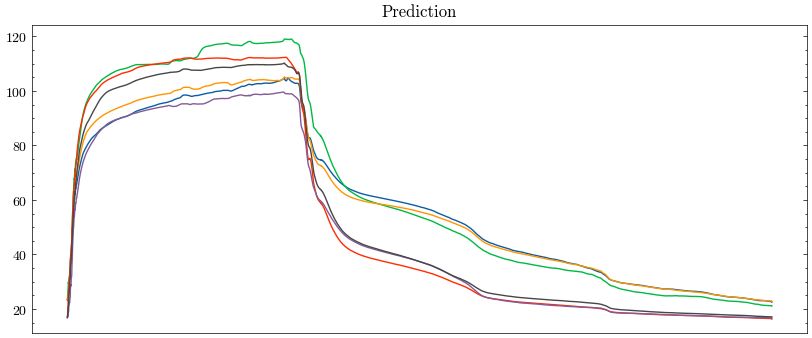

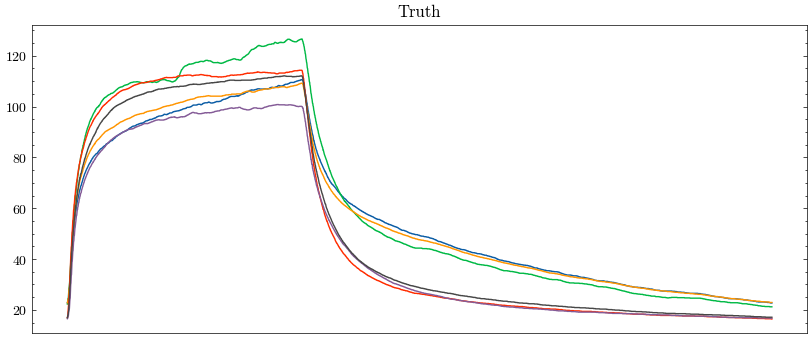

In [12]:
import numpy as np
models = torch.load('withState3w320002.pt')
labels = 4
start = 0
end = -1
plot_step = 50
loads,preds = myModels.predict_varylength(models,params,labels,start,end,mask=True)
print (Metrics.Com_pearsonr(loads,preds))
plt.figure(figsize=(10,4))
plt.plot(preds.detach().numpy())
plt.title('Prediction')
plt.xticks(np.arange(0, end - start + 1, step=plot_step), np.arange(start, end + 1, step=plot_step))
plt.show()
plt.figure(figsize=(10,4))
plt.plot(loads.cpu().detach().numpy())
plt.title('Truth')
plt.xticks(np.arange(0, end - start + 1, step=plot_step), np.arange(start, end + 1, step=plot_step))
plt.show()

In [ ]:
def addGaussianNoise(Datas,Lambda,device):
    torch.manual_seed(123)
    Datas = Datas.to(device)
    shape = Datas[:,-1].size()
    noise = torch.randn(shape).to(device)
    torch.randn(shape,out=noise)
    Datas[:,-1] = Datas[:,-1] + Lambda*torch.mul(noise,torch.mean(Datas[:,-1]))
    return Datas


In [223]:
from scipy.stats import pearsonr
corr,_ = pearsonr(loads.flatten().detach().numpy(),preds.flatten().detach().numpy())
(1-corr)

0.09485358055572046

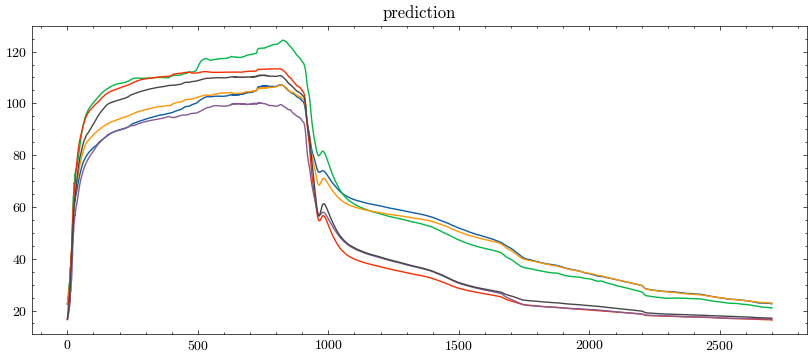

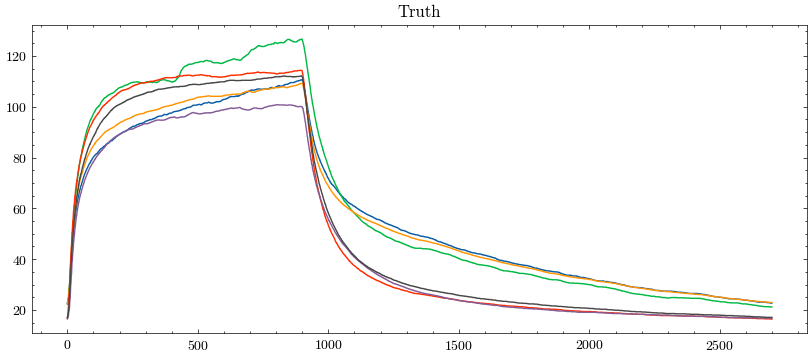

In [187]:
models = torch.load('withState3w320002.pt')
labels = 4
strains = dataset.getTensorFromFile(params['Strains_FileName'][labels],params['paths'],params['state'])
strains = dataset.mask_input(strains.to(params['device']),params)
start = 0
end = None
strains=strains[:,start:end,:]
loads = dataset.getTensorFromFile(params['Loads_FileName'][labels],params['paths'],params['state'])
pred = models(strains.to(params['device'])).cpu()
plt.figure(figsize=(10,4))
plt.plot(pred[0].detach().numpy())
plt.title('prediction')
plt.show()
plt.figure(figsize=(10,4))
plt.plot(loads[0][start:end,:].cpu().detach().numpy())
plt.title('Truth')
plt.show()

In [ ]:
import LossFn

models = myModels.deepLSTM(params).to(device)
loss_fn = LossFn.UncertaintyLoss(params)
if params['Robust_loss'] == True:
    all_parameters = list(models.parameters()) + list(loss_fn.parameters())
else:
    all_parameters = models.parameters()
optimizer = optim.Adam(all_parameters, params['lr'])
for _,data in enumerate(test_loader):
    optimizer.zero_grad()
    x = data[0].clone().detach().requires_grad_(True).float()
    x = dataset.mask_input(x,params).to(params['device'])
    y = data[1].clone().detach().requires_grad_(True).float()
    out = models(x)
    loss = loss_fn(out,y)
    print (loss)
    loss.backward()
    optimizer.step()
    break